In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from tensorflow.keras.layers import Dropout, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
img_shape = (28, 28, 1)

In [3]:
def prepare_data(num_generated):
    y = []
    for i in range(10):
        data = np.load('data/fashion/' + str(i) + '-' +  'train.npy', allow_pickle=True)
        for _ in range(data.shape[0]):
            y.append(i)
        if i == 0:
            X = data
        else:
            X = np.concatenate((X, data), axis=0)
    
    # separate validation data
    X, y = shuffle(X, y, random_state=0)
    num_val = int(X.shape[0]*.2)
    X_val = X[0:num_val]
    y_val = y[0:num_val]

    X = X[num_val:]
    y = y[num_val:]

    X_val = np.expand_dims(X_val, axis=3)
    y_val = np.array(keras.utils.to_categorical(y_val, 10))
    
    # add generated data to training dataset 
    if num_generated > 0:
        for i in range(10):
            generated_data = np.load('data/fashion/' + str(i) + '-' +  'generated.npy', allow_pickle=True)
            for _ in range(num_generated):
                y.append(i)
            generated_data = shuffle(generated_data, random_state=0)    
            X = np.concatenate((X, generated_data[:num_generated]), axis=0)
   
    # one hot encode target output
    y = np.array(keras.utils.to_categorical(y, 10))
    
    X = np.expand_dims(X, axis=3)
    X, y = shuffle(X, y, random_state=0)
    
    return X, y, X_val, y_val

In [4]:
def only_generated():
    y = []
    for i in range(10):
        data = np.load('data/fashion/' + str(i) + '-' +  'train.npy', allow_pickle=True)
        for _ in range(data.shape[0]):
            y.append(i)
        if i == 0:
            X = data
        else:
            X = np.concatenate((X, data), axis=0)
    
    # separate validation data
    X, y = shuffle(X, y, random_state=0)
    num_val = int(X.shape[0]*.2)
    X_val = X[0:num_val]
    y_val = y[0:num_val]

    y = []

    X_val = np.expand_dims(X_val, axis=3)
    y_val = np.array(keras.utils.to_categorical(y_val, 10))
    
    # add generated data to training dataset 
    for i in range(10):
        generated_data = np.load('data/fashion/' + str(i) + '-' +  'generated.npy', allow_pickle=True)
        generated_data = generated_data[0:1500]
        if i == 0:
            X = generated_data
        else:
            X = np.concatenate((X, generated_data), axis=0)
        for _ in range(generated_data.shape[0]):
            y.append(i)
        
    # one hot encode target output
    y = np.array(keras.utils.to_categorical(y, 10))
    
    X = np.expand_dims(X, axis=3)
    X, y = shuffle(X, y, random_state=0)
    
    return X, y, X_val, y_val
#X_train, y_train, X_validation, y_validation = only_generated()

In [5]:
X_train, y_train, X_validation, y_validation = prepare_data(1250)

In [6]:
X_test = np.load('data/fashion/X-test.npy')
X_test = X_test / 255
X_test = np.expand_dims(X_test, axis=3)
y_test = np.load('data/fashion/y-test.npy')

In [7]:
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=(img_shape)))
model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(2, 2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [8]:
early_stop = EarlyStopping(monitor='categorical_accuracy', mode='max', verbose=1, patience=3)

In [ ]:
history = model.fit(X_train, y_train, verbose=2, epochs=75, batch_size=256, validation_data=(X_validation, y_validation), callbacks=[early_stop])

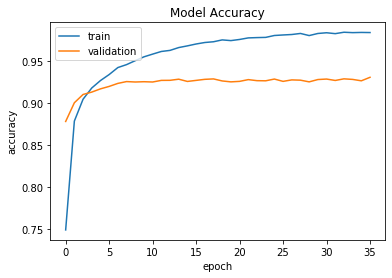

In [10]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

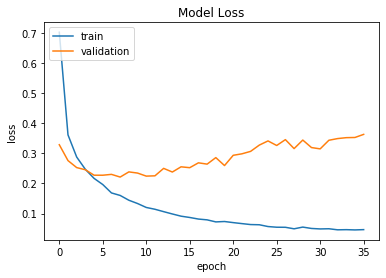

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
predictions = model.predict(X_test)

In [13]:
predictionList = []
for pred in predictions:
    predictionList.append(np.argmax(pred))

In [14]:
correct = 0
total = 0
for i in range(len(predictionList)):
    if predictionList[i] == y_test[i]:
        correct += 1
    total += 1

In [15]:
# calculate accuracy and F1 score
print('Accuracy: ' + str(round(correct/total, 4)))
print('F1 Score: ' + str(f1_score(y_test, predictionList, average='micro')))

Accuracy: 0.9313
F1 Score: 0.9312999999999999


TEST ACCURACY // AVERAGE  
0 generated: 0.9267, 0.9282, 0.9269 // 0.9273  
250 generated: 0.9289, 0.9265, 0.9263 // 0.9272     
500 generated: 0.9293, 0.9264, 0.9264 // 0.9274    
750 generated: 0.9269, 0.9263, 0.9276 // 0.9269    
1000 generated: 0.928, 0.9273, 0.9294 // 0.9282     
1250 generated: 0.929, 0.9276, 0.9313 //  0.9293   
1500 generated: 0.927, 0.9262, 0.9283 // 0.9272

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    ax.set_ylim(len(classes)-0.5, -0.5)
    fig.set_dpi(100)
    return ax

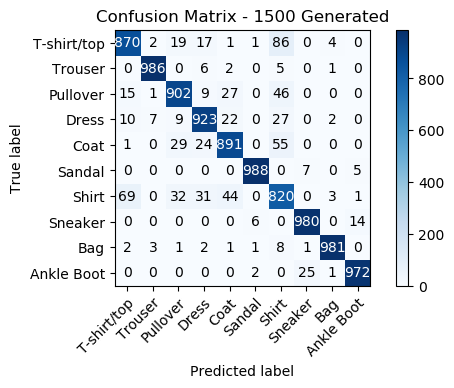

In [28]:
plot_confusion_matrix(y_test, predictionList, classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'], 
                      title='Confusion Matrix - 1500 Generated')